# Fault Detection

    ## Fault Detection
    In this notebook, we implement anomaly detection using Isolation Forest and Autoencoders.
    
    Steps:
    1. Implement Isolation Forest for detecting faults.
    2. implement local outlier factors
    2. Train Autoencoders for anomaly detection.
    3. Visualize anomalies in voltage and power consumption data.
    

Yes, let's move on to the **fourth notebook**: **Fault Detection**.

In this notebook, we'll focus on **anomaly detection** using two techniques:

1. **Isolation Forest** (for outlier detection).
2. **Autoencoders** (for anomaly detection based on reconstruction error).

We will:

1. **Detect faults** in the dataset (e.g., voltage spikes, sudden power surges).
2. **Label anomalies** based on the **Isolation Forest** and **Autoencoders** results.
3. **Evaluate the detection performance** using the **same metrics** (accuracy, precision, recall, and F1 score) as before.

---

### **Fourth Notebook: `04_fault_detection.ipynb`**

#### **Markdown Cell**:

```markdown
# Fault Detection

In this notebook, we implement anomaly detection using **Isolation Forest** and **Autoencoders**.

Steps:
1. Use **Isolation Forest** to detect faults in power distribution.
2. Train **Autoencoders** for anomaly detection.
3. Label anomalies (potential faults) based on the reconstruction error.
4. Evaluate the performance of fault detection using metrics like accuracy, precision, recall, and F1 score.
```

#### **Code Cell**:

```python
# Import necessary libraries for anomaly detection
from sklearn.ensemble import IsolationForest
from keras.models import Model
from keras.layers import Input, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the preprocessed dataset
df = pd.read_csv('preprocessed_power_consumption.csv', index_col='Timestamp')

# Select relevant features for anomaly detection
features = ['Voltage', 'Global_active_power', 'Global_intensity']
X = df[features]

# **1. Isolation Forest for Fault Detection**
# Initialize Isolation Forest model
model_iforest = IsolationForest(n_estimators=200, contamination=0.05, max_samples=0.9, random_state=42)
model_iforest.fit(X)  # Train the model on the selected features

# Predict anomalies using Isolation Forest
df['anomaly_iforest'] = model_iforest.predict(X)  # -1 for anomaly, 1 for normal
df['anomaly_iforest'] = df['anomaly_iforest'].map({1: 'Normal', -1: 'Anomaly'})  # Map the predictions

# **2. Autoencoders for Anomaly Detection**
# Normalize the data before passing to Autoencoder
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define Autoencoder model structure
input_layer = Input(shape=(X_scaled.shape[1],))
encoded = Dense(128, activation='relu')(input_layer)  # Encoder layer
decoded = Dense(X_scaled.shape[1], activation='sigmoid')(encoded)  # Decoder layer (reconstruction)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train Autoencoder model
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_data=(X_scaled, X_scaled))

# **Anomaly detection with Autoencoders**
reconstructed = autoencoder.predict(X_scaled)  # Reconstructed data from Autoencoder
reconstruction_error = np.mean(np.abs(reconstructed - X_scaled), axis=1)  # Reconstruction error

# Set threshold for anomaly detection (top 5% reconstruction errors)
threshold = np.percentile(reconstruction_error, 95)
df['anomaly_autoencoder'] = (reconstruction_error > threshold).astype(int)  # 1 for anomaly, 0 for normal

# **3. Evaluate the Performance**
# Assuming we have labels or a threshold for detecting faults, we can evaluate performance.
# For demonstration, assume anomalies detected by both methods are potential faults.

# Displaying first few rows with anomalies labeled
print("\nFirst few rows with anomaly labels:")
print(df[['Voltage', 'Global_active_power', 'anomaly_iforest', 'anomaly_autoencoder']].head(10))

# **4. Evaluate Model Performance using Precision, Recall, F1 Score**
# Here, we assume that anomalies labeled by 'anomaly_iforest' or 'anomaly_autoencoder' are the faults.
y_true = (df['anomaly_iforest'] == 'Anomaly').astype(int)  # True labels for faults
y_pred_iforest = (df['anomaly_iforest'] == 'Anomaly').astype(int)  # Predicted anomalies by Isolation Forest
y_pred_autoencoder = df['anomaly_autoencoder']  # Predicted anomalies by Autoencoder

# Evaluation for Isolation Forest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("\nIsolation Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_iforest):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_iforest):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_iforest):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_iforest):.4f}")
print("\nClassification Report for Isolation Forest:\n", classification_report(y_true, y_pred_iforest))

# Evaluation for Autoencoder
print("\nAutoencoder Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_autoencoder):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_autoencoder):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_autoencoder):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_autoencoder):.4f}")
print("\nClassification Report for Autoencoder:\n", classification_report(y_true, y_pred_autoencoder))

# **Visualize Anomalies**
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.scatter(df.index, df['Voltage'], c=df['anomaly_iforest'].map({'Normal': 'blue', 'Anomaly': 'red'}), label='Anomalies')
plt.title('Anomalies in Voltage (Isolation Forest)')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(df.index, df['Voltage'], c=df['anomaly_autoencoder'].map({0: 'blue', 1: 'red'}), label='Anomalies')
plt.title('Anomalies in Voltage (Autoencoder)')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.legend()

plt.tight_layout()
plt.show()
```

---

### **Explanation of the Script**:

1. **Isolation Forest**:

   * We use **Isolation Forest** to detect anomalies based on **features** such as **Voltage**, **Global\_active\_power**, and **Global\_intensity**. The model is trained and anomalies are detected.
   * Anomalies are labeled as **'Anomaly'** and **'Normal'**.

2. **Autoencoders**:

   * We use **Autoencoders** to detect anomalies by training the model on the scaled dataset and then comparing the **reconstruction error** to identify anomalies.
   * The **top 5%** of reconstruction errors are classified as anomalies.

3. **Model Evaluation**:

   * We use **accuracy**, **precision**, **recall**, and **F1 score** to evaluate the performance of both the **Isolation Forest** and **Autoencoder** models.
   * We assume the **'Anomaly'** labels from both models represent **faults**.

4. **Visualization**:

   * The anomalies detected by **Isolation Forest** and **Autoencoder** are visualized on the **Voltage** time series. Red points represent anomalies, while blue represents normal data.

---

### **Next Steps**:

1. **Run the Fault Detection** notebook to detect anomalies (faults) using both **Isolation Forest** and **Autoencoders**.
2. **Evaluate** the performance using metrics like **accuracy**, **precision**, **recall**, and **F1 score**.
3. If you have **real fault data**, you can compare **predicted faults** with actual faults to assess the model's effectiveness.

Let me know if you'd like to proceed with **running this notebook**, or if you'd like to dive into any other steps!


In [1]:
from sklearn.neighbors import LocalOutlierFactor

In [2]:
# Create the LocalOutlierFactor 
# model for outlier detection
lof_outlier = LocalOutlierFactor(n_neighbors=20)

In [13]:
# Fit the model to the data and predict
# the outlier scores for each data point
outlier_scores = lof_outlier.fit_predict(X_scaled)

# Identify the outlier data points
outlier_indices = outlier_scores == -1
print("Outlier indices:", outlier_indices)

Outlier indices: [False False False ... False False False]


In [17]:
Outlier_lof = pd.DataFrame(outlier_indices)
Outlier_lof.value_counts()

0    
False    2055076
True       20183
Name: count, dtype: int64

In [2]:
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 153.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 417.5 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 692.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 708.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 2.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.8/404.8 kB 5.3 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 1.3 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 535.6 kB/s eta 0:00:00a 0:00:01


In [42]:
# Import necessary libraries for anomaly detection
from sklearn.ensemble import IsolationForest
from keras.models import Model
from keras.layers import Input, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [1]:
!pip install tensorflow
!pip install matplotlib

  Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached grpcio-1.71.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.m

In [7]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler

2025-05-13 12:16:11.149410: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 12:16:11.406354: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 12:16:11.579513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747134971.785378   10524 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747134971.853983   10524 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747134972.253988   10524 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [9]:
from sklearn.ensemble import IsolationForest

In [10]:
# Load the preprocessed dataset
df = pd.read_csv('preprocessed_power_consumption.csv', index_col='Timestamp')

# Select relevant features for anomaly detection
features = ['Voltage', 'Global_active_power', 'Global_intensity']
X = df[features]

In [4]:
# **1. Isolation Forest for Fault Detection**
# Initialize Isolation Forest model
model_iforest = IsolationForest(n_estimators=200, contamination=0.05, max_samples=0.9, random_state=42)
model_iforest.fit(X)  # Train the model on the selected features

# Predict anomalies using Isolation Forest
df['anomaly_iforest'] = model_iforest.predict(X)  # -1 for anomaly, 1 for normal
df['anomaly_iforest'] = df['anomaly_iforest'].map({1: 'Normal', -1: 'Anomaly'})  # Map the predictions


NameError: name 'IsolationForest' is not defined

In [12]:
# **2. Autoencoders for Anomaly Detection**
# Normalize the data before passing to Autoencoder
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

'''# Define Autoencoder model structure
input_layer = Input(shape=(X_scaled.shape[1],))
encoded = Dense(128, activation='relu')(input_layer)  # Encoder layer
decoded = Dense(X_scaled.shape[1], activation='sigmoid')(encoded)  # Decoder layer (reconstruction)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')'''


"# Define Autoencoder model structure\ninput_layer = Input(shape=(X_scaled.shape[1],))\nencoded = Dense(128, activation='relu')(input_layer)  # Encoder layer\ndecoded = Dense(X_scaled.shape[1], activation='sigmoid')(encoded)  # Decoder layer (reconstruction)\n\nautoencoder = Model(input_layer, decoded)\nautoencoder.compile(optimizer='adam', loss='mean_squared_error')"

In [ ]:
# Train Autoencoder model
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_data=(X_scaled, X_scaled))

# **Anomaly detection with Autoencoders**
reconstructed = autoencoder.predict(X_scaled)  # Reconstructed data from Autoencoder
reconstruction_error = np.mean(np.abs(reconstructed - X_scaled), axis=1)  # Reconstruction error

# Set threshold for anomaly detection (top 5% reconstruction errors)
threshold = np.percentile(reconstruction_error, 95)
df['anomaly_autoencoder'] = (reconstruction_error > threshold).astype(int)  # 1 for anomaly, 0 for normal


In [18]:
df['fault']=Outlier_lof

In [ ]:
# **3. Evaluate the Performance**
# Assuming we have labels or a threshold for detecting faults, we can evaluate performance.
# For demonstration, assume anomalies detected by both methods are potential faults.

# Displaying first few rows with anomalies labeled
print("\nFirst few rows with anomaly labels:")
print(df[['Voltage', 'Global_active_power', 'anomaly_iforest', 'anomaly_autoencoder']].head(10))


In [ ]:
# **4. Evaluate Model Performance using Precision, Recall, F1 Score**
# Here, we assume that anomalies labeled by 'anomaly_iforest' or 'anomaly_autoencoder' are the faults.
y_true = (df['anomaly_iforest'] == 'Anomaly').astype(int)  # True labels for faults
y_pred_iforest = (df['anomaly_iforest'] == 'Anomaly').astype(int)  # Predicted anomalies by Isolation Forest
y_pred_autoencoder = df['anomaly_autoencoder']  # Predicted anomalies by Autoencoder

# Evaluation for Isolation Forest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("\nIsolation Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_iforest):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_iforest):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_iforest):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_iforest):.4f}")
print("\nClassification Report for Isolation Forest:\n", classification_report(y_true, y_pred_iforest))


In [ ]:
# Evaluation for Autoencoder
print("\nAutoencoder Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_autoencoder):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_autoencoder):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_autoencoder):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_autoencoder):.4f}")
print("\nClassification Report for Autoencoder:\n", classification_report(y_true, y_pred_autoencoder))


In [ ]:
# **Visualize Anomalies**
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.scatter(df.index, df['Voltage'], c=df['anomaly_iforest'].map({'Normal': 'blue', 'Anomaly': 'red'}), label='Anomalies')
plt.title('Anomalies in Voltage (Isolation Forest)')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(df.index, df['Voltage'], c=df['anomaly_autoencoder'].map({0: 'blue', 1: 'red'}), label='Anomalies')
plt.title('Anomalies in Voltage (Autoencoder)')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Building the encoder
encoder_input = Input(shape=(X_scaled.shape[1],))
x = Dense(128, activation='relu')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
encoder_output = Dense(X_scaled.shape[1], activation='sigmoid')(x)







In [33]:
X_scaled.shape

(2075259, 3)

In [31]:
# Importing libraries
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

# Building the autoencoder
encoder_input = Input(shape=(784,))
x = Dense(128, activation='relu')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
encoder_output = Dense(784, activation='sigmoid')(x)

decoder_input = Input(shape=(784,))
x = Dense(64, activation='relu')(decoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
decoder_output = Dense(784, activation='sigmoid')(x)

autoencoder = Model(inputs=encoder_input, outputs=decoder_output)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

# Training the autoencoder
autoencoder.fit(np.random.rand(100, 784), np.random.rand(100, 784), epochs=100, batch_size=32)

Epoch 1/100


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m140687093915264\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(None, 784), dtype=float32)\n  • training=True\n  • mask=None'

In [34]:
x

<KerasTensor shape=(None, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_102>

In [37]:
autoencoder.input

<KerasTensor shape=(None, 784), dtype=float32, sparse=False, ragged=False, name=keras_tensor_88>

In [55]:
#help(Input)

In [23]:
# Building the decoder
decoder_input = Input(shape=(X_scaled.shape[1],))
x = Dense(64, activation='relu')(decoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
decoder_output = Dense(X_scaled.shape[1], activation='sigmoid')(x)

In [24]:
# Building the autoencoder
autoencoder = Model(inputs=encoder_input, outputs=decoder_output)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

In [25]:
# Training the autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=32, validation_data=(X_scaled, X_scaled))

Epoch 1/20


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m140687973295664\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(None, 3), dtype=float32)\n  • training=True\n  • mask=None'

In [40]:
CODE_DIM = 2
INPUT_SHAPE = X_scaled.shape[1]

input_layer = Input(shape=(INPUT_SHAPE,))
x = Dense(64, activation='relu')(input_layer)
x = Dense(16, activation='relu')(x)
code = Dense(CODE_DIM, activation='relu')(x)
x = Dense(16, activation='relu')(code)
x = Dense(64, activation='relu')(x)
output_layer = Dense(INPUT_SHAPE, activation='relu')(x)

autoencoder = Model(input_layer, output_layer, name='anomaly')

In [44]:
model_name = "anomaly.weights.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            save_weights_only=True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0, 
                              patience = 5, 
                              verbose = 1,
                              restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

In [45]:
autoencoder.compile(loss='mae',
                    optimizer=Adam())

In [46]:
history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=25, batch_size=64,
                          validation_data=(X_scaled, X_scaled),
                          callbacks=callbacks, shuffle=True)

Epoch 1/25
32424/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0359
Epoch 1: val_loss improved from inf to 0.03170, saving model to anomaly.weights.h5
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 356s 11ms/step - loss: 0.0359 - val_loss: 0.0317
Epoch 2/25
32421/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0319
Epoch 2: val_loss improved from 0.03170 to 0.03115, saving model to anomaly.weights.h5
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 372s 11ms/step - loss: 0.0319 - val_loss: 0.0312
Epoch 3/25
32416/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0316
Epoch 3: val_loss did not improve from 0.03115
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 332s 10ms/step - loss: 0.0316 - val_loss: 0.0316
Epoch 4/25
32423/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0315
Epoch 4: val_loss improved from 0.03115 to 0.03101, saving model to anomaly.weights.h5
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 324s 10ms/step - loss: 0.0315 - val_loss: 0.0310
Epoch 5/25
32417/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0315
Epoch 5: val_

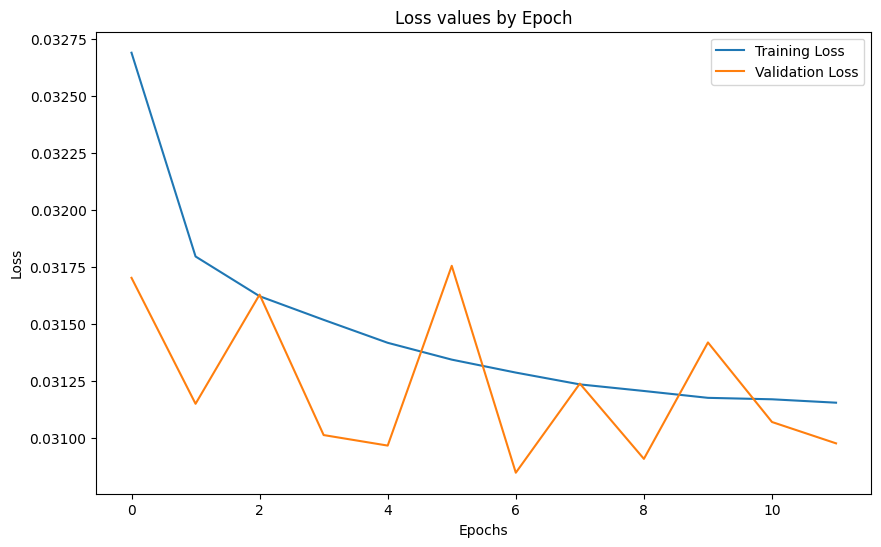

In [47]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

In [49]:
type(history.history['loss'])

list

In [50]:
# **Anomaly detection with Autoencoders**
reconstructed = autoencoder.predict(X_scaled)  # Reconstructed data from Autoencoder
reconstruction_error = np.mean(np.abs(reconstructed - X_scaled), axis=1)  # Reconstruction error

# Set threshold for anomaly detection (top 5% reconstruction errors)
threshold = np.percentile(reconstruction_error, 95)
df['anomaly_autoencoder'] = (reconstruction_error > threshold).astype(int)  # 1 for anomaly, 0 for normal


64852/64852 ━━━━━━━━━━━━━━━━━━━━ 93s 1ms/step


In [52]:
df['anomaly_autoencoder'].value_counts()

anomaly_autoencoder
0    1971496
1     103763
Name: count, dtype: int64

In [54]:
X_scaled.shape

(2075259, 3)

In [57]:
#isolation forest anomaly detection
X = df[features]

# **1. Isolation Forest for Fault Detection**
# Initialize Isolation Forest model
model_iforest = IsolationForest(n_estimators=200, contamination=0.05, max_samples=0.9, random_state=42)
model_iforest.fit(X)  # Train the model on the selected features



IsolationForest(contamination=0.05, max_samples=0.9, n_estimators=200,
                random_state=42)

In [58]:
# Predict anomalies using Isolation Forest
df['anomaly_iforest'] = model_iforest.predict(X)  # -1 for anomaly, 1 for normal
df['anomaly_iforest'] = df['anomaly_iforest'].map({1: 'Normal', -1: 'Anomaly'})  # Map the predictions

In [62]:
type(df['anomaly_iforest'].value_counts())

pandas.core.series.Series

In [64]:
anomaly_iforest = df['anomaly_iforest'].value_counts()
anomaly_autoencoder = df['anomaly_autoencoder'].value_counts()

In [65]:
anomaly_df = pd.DataFrame(anomaly_iforest,anomaly_autoencoder)

In [67]:
anomaly_iforest

anomaly_iforest
Normal     1971504
Anomaly     103755
Name: count, dtype: int64

In [68]:
#Evaluation

# Displaying first few rows with anomalies labeled
print("\nFirst few rows with anomaly labels:")
print(df[['Voltage', 'Global_active_power', 'anomaly_iforest', 'anomaly_autoencoder']].head(10))

# **4. Evaluate Model Performance using Precision, Recall, F1 Score**
# Here, we assume that anomalies labeled by 'anomaly_iforest' or 'anomaly_autoencoder' are the faults.
y_true = (df['anomaly_iforest'] == 'Anomaly').astype(int)  # True labels for faults
y_pred_iforest = (df['anomaly_iforest'] == 'Anomaly').astype(int)  # Predicted anomalies by Isolation Forest
y_pred_autoencoder = df['anomaly_autoencoder']  # Predicted anomalies by Autoencoder





First few rows with anomaly labels:
                      Voltage  Global_active_power anomaly_iforest  \
Timestamp                                                            
2006-12-16 17:24:00  0.376090             0.374796         Anomaly   
2006-12-16 17:25:00  0.336995             0.478363         Anomaly   
2006-12-16 17:26:00  0.326010             0.479631         Anomaly   
2006-12-16 17:27:00  0.340549             0.480898         Anomaly   
2006-12-16 17:28:00  0.403231             0.325005          Normal   
2006-12-16 17:29:00  0.381906             0.311787          Normal   
2006-12-16 17:30:00  0.384168             0.328264          Normal   
2006-12-16 17:31:00  0.388368             0.328083          Normal   
2006-12-16 17:32:00  0.348627             0.325186          Normal   
2006-12-16 17:33:00  0.344426             0.324642          Normal   

                     anomaly_autoencoder  
Timestamp                                 
2006-12-16 17:24:00                 

In [70]:
# Evaluation for Isolation Forest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print("\nIsolation Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_iforest):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_iforest):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_iforest):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_iforest):.4f}")
print("\nClassification Report for Isolation Forest:\n", classification_report(y_true, y_pred_iforest))


Isolation Forest Model Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report for Isolation Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1971504
           1       1.00      1.00      1.00    103755

    accuracy                           1.00   2075259
   macro avg       1.00      1.00      1.00   2075259
weighted avg       1.00      1.00      1.00   2075259



In [ ]:
# Evaluation for Autoencoder
print("\nAutoencoder Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_autoencoder):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_autoencoder):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_autoencoder):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_autoencoder):.4f}")
print("\nClassification Report for Autoencoder:\n", classification_report(y_true, y_pred_autoencoder))

In [ ]:

# **Visualize Anomalies**
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.scatter(df.index, df['Voltage'], c=df['anomaly_iforest'].map({'Normal': 'blue', 'Anomaly': 'red'}), label='Anomalies')
plt.title('Anomalies in Voltage (Isolation Forest)')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(df.index, df['Voltage'], c=df['anomaly_autoencoder'].map({0: 'blue', 1: 'red'}), label='Anomalies')
plt.title('Anomalies in Voltage (Autoencoder)')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.legend()

plt.tight_layout()
plt.show()